# **TP08 - KMEAN Y EM**

In [51]:
import requests
import io
import zipfile
import librosa
from collections import defaultdict

from IPython.display import Audio


import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import stft, get_window
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import GaussianMixture


import pandas as pd

from scipy.special import softmax

In [52]:
# 1. Descargar ZIP en memoria
url = 'https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/instrumentos.zip'
resp = requests.get(url)
resp.raise_for_status()
zip_buf = io.BytesIO(resp.content)

# 2. Abrir el ZIP y agrupar archivos .mp3 por instrumento
with zipfile.ZipFile(zip_buf) as z:
    all_files = [n for n in z.namelist() if n.endswith('.mp3')]  # ✅ Filtrar solo .mp3
    instrumentos_dict = defaultdict(list)
    for fn in all_files:
        instrumento = fn.split('_')[0]
        instrumentos_dict[instrumento].append(fn)

    # 3. Inicializar dicts para train/test
    X_train, X_test = {}, {}
    sr = 44100  # frecuencia de muestreo deseada

    # 4. Cargar audio y separar última muestra como test
    for inst, archivos in instrumentos_dict.items():
        archivos.sort()
        seniales = []
        for fn in archivos:
            with z.open(fn) as f:
                audio, _ = librosa.load(f, sr=sr)
            seniales.append(audio)

        # Asignar todas menos la última a train, y la última a test
        X_train[inst] = seniales[:-1]
        X_test[inst]  = seniales[-1]

# 5. Resultados
print(f"Instrumentos cargados: {list(X_train.keys())}")
print({k: len(v) for k, v in X_train.items()}, "muestras de entrenamiento por instrumento")
print({k: 1 for k in X_test}, "muestra de testeo por instrumento")




Instrumentos cargados: ['clarinet', 'guitar', 'saxophone', 'trumpet', 'violin']
{'clarinet': 4, 'guitar': 4, 'saxophone': 4, 'trumpet': 4, 'violin': 4} muestras de entrenamiento por instrumento
{'clarinet': 1, 'guitar': 1, 'saxophone': 1, 'trumpet': 1, 'violin': 1} muestra de testeo por instrumento


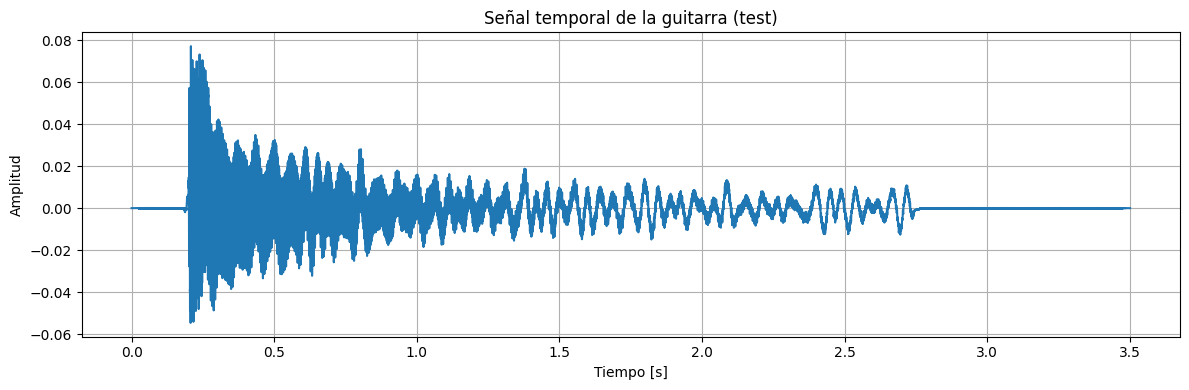

In [53]:
# Obtener la señal de testeo del instrumento "guitar"
guitar = X_test["guitar"]
sr = 44100  # Si conocés la frecuencia real podés reemplazarla

# Eje de tiempo
t = np.linspace(0, len(guitar) / sr, len(guitar))

plt.figure(figsize=(12, 4))
plt.plot(t, guitar)
plt.title("Señal temporal de la guitarra (test)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:

Audio(data=guitar, rate=sr)


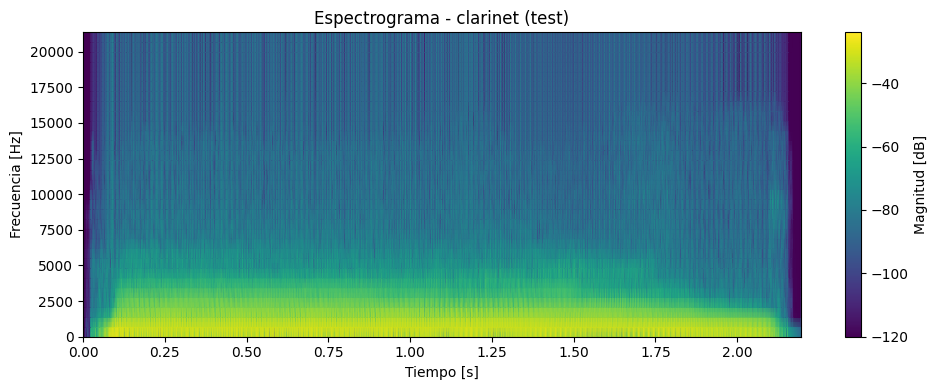

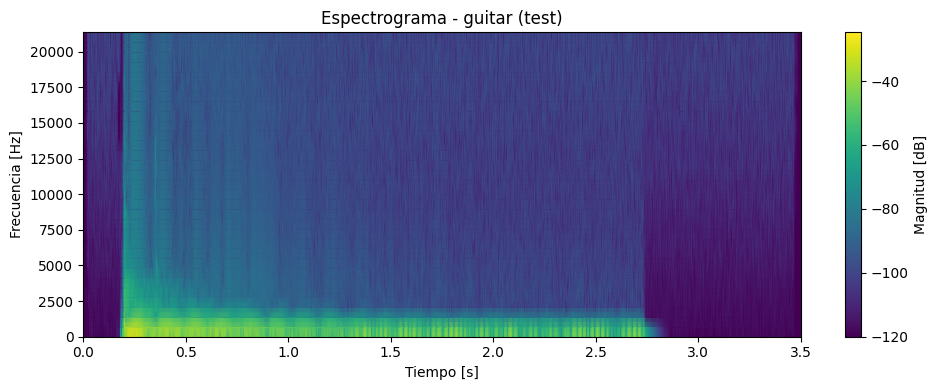

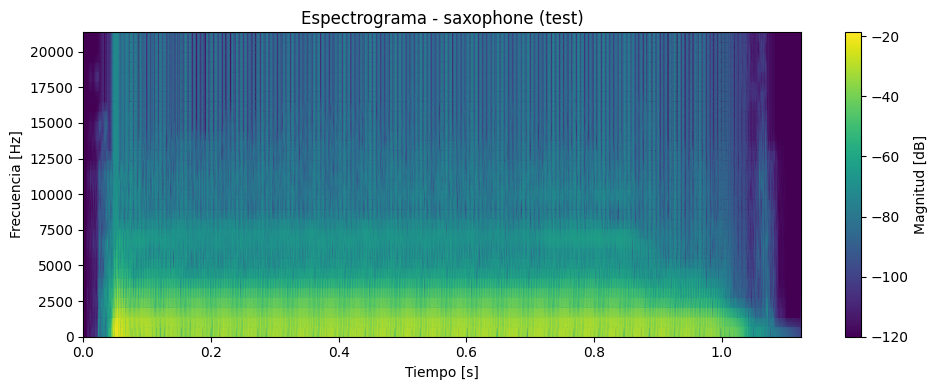

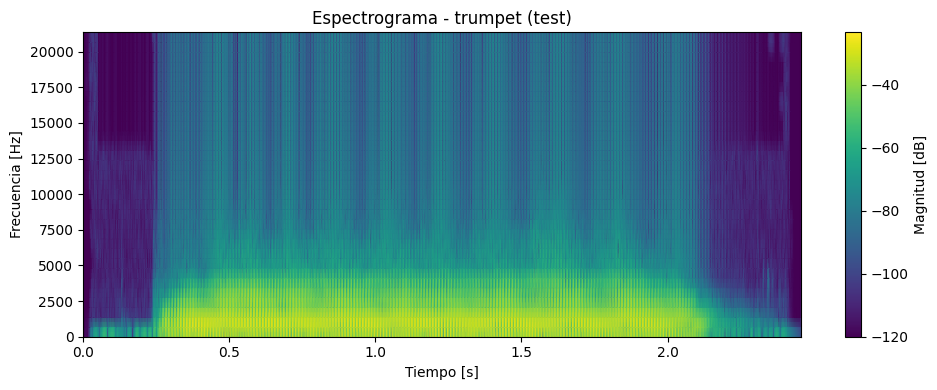

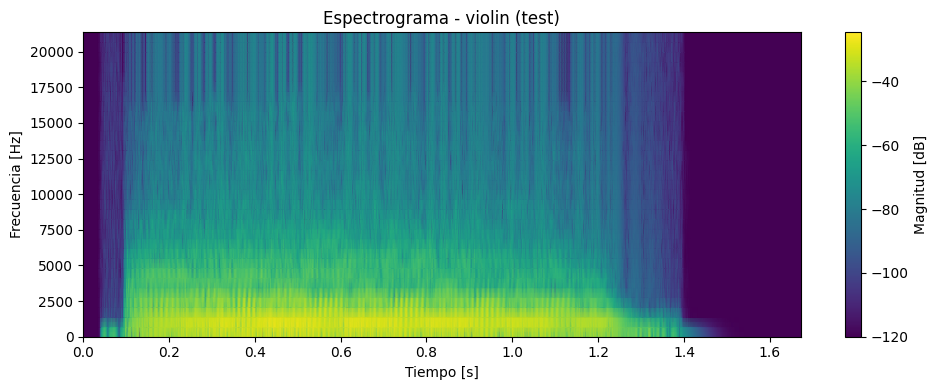

In [55]:
def obtener_espectrograma(senal, sr, fft_size=64, hop_size=None):
    ventana = get_window("hamming", fft_size)
    if hop_size is None:
        hop_size = fft_size // 2  # 50% solapamiento
    f, t, Zxx = stft(senal, fs=sr,
                     window=ventana,
                     nperseg=fft_size,
                     noverlap=fft_size - hop_size)
    # Solo mitad positiva
    f = f[:fft_size // 2]
    S = 20 * np.log10(np.abs(Zxx[:fft_size // 2, :]) + 1e-6)  # dB
    return t, f, S

# Parámetros
fft_size = 64
hop_size = fft_size // 2
sr = 44100  # tu frecuencia de muestreo

# Generar espectrograma para cada señal de testeo
for instrumento, senal in X_test.items():
    t, f, S = obtener_espectrograma(senal, sr,
                                     fft_size=fft_size,
                                     hop_size=hop_size)

    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t, f, S, shading='gouraud')
    plt.title(f"Espectrograma - {instrumento} (test)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Frecuencia [Hz]")
    plt.colorbar(label="Magnitud [dB]")
    plt.tight_layout()
    plt.show()



In [67]:
from scipy.signal import stft, get_window
import numpy as np

def generar_frames_fft(signals, sr, fft_size=64, hop_size=None, window='hamming'):
    """
    Convierte una lista de señales en una lista de frames de FFT,
    tomando manualmente la parte positiva del espectro.
    """
    if hop_size is None:
        hop_size = fft_size // 2

    ventana = get_window(window, fft_size)
    all_frames = []

    for sig in signals:
        # STFT con espectro completo
        f, t, Zxx = stft(
            sig,
            fs=sr,
            window=ventana,
            nperseg=fft_size,
            noverlap=fft_size - hop_size
        )
        # Zxx tiene forma (fft_size, n_frames)
        # Cortamos manualmente la mitad positiva (incluye DC y Nyquist)
        half = fft_size // 2
        Zxx_pos = Zxx[:half, :]

        magnitudes = np.abs(Zxx_pos)  # magnitud compleja

        # Opcional: convertir a dB
        # magnitudes = 20 * np.log10(magnitudes + 1e-9)

        # Extendemos la lista con cada frame (columna)
        for frame in magnitudes.T:
            all_frames.append(frame)

    return all_frames




# Asumiendo que ya tienes:
#   X_train (dict: instrumento → list de señales)
#   sr, generar_frames_fft

# 1) Inicializar dict para frames de train
X_train_frames = {}

# 2) Para cada instrumento, generar sus frames directamente
for inst, señales_inst in X_train.items():
    # generar frames de FFT para la lista de señales de este instrumento
    frames = generar_frames_fft(señales_inst, sr, fft_size=64, hop_size=32)
    
    # guardar en el diccionario
    X_train_frames[inst] = frames

# 3) Verificación rápida
for inst, frs in X_train_frames.items():
    print(f"{inst}: {len(frs)} frames")


clarinet: 11488 frames
guitar: 28912 frames
saxophone: 7168 frames
trumpet: 13612 frames
violin: 9040 frames


In [68]:
class Kmeans:
    def __init__(self, n_clusters=6, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.centroids = None
    
    def fit(self, X):
        np.random.seed(self.random_state)
        
        # Inicializar centroides aleatoriamente desde X
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[indices]
        
        for it in range(self.max_iter):
            # Asignar cada punto a cluster más cercano
            distancias = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
            labels = np.argmin(distancias, axis=1)
            
            # Actualizar centroides
            nuevos_centroides = np.array([X[labels == k].mean(axis=0) if np.any(labels==k) else self.centroids[k] 
                                          for k in range(self.n_clusters)])
            
            # Chequear convergencia
            dif = np.linalg.norm(self.centroids - nuevos_centroides)
            self.centroids = nuevos_centroides
            if dif < self.tol:
                break
    
    def predict(self, X):
        distancias = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
        return np.argmin(distancias, axis=1)


kmeans_models = {}

for instrumento, frames in X_train_frames.items():
    X_inst = np.vstack(frames)  # Convierte lista de frames en un array 2D

    print(f"\nEntrenando KMeans para instrumento: {instrumento}")
    print(f" - Cantidad de frames (muestras): {X_inst.shape[0]}")
    print(f" - Dimensión de cada frame: {X_inst.shape[1]}")
    
    model = Kmeans(n_clusters=6, max_iter=100, random_state=42)
    model.fit(X_inst)
    
    print(f" - Centroides finales shape: {model.centroids.shape}")
    kmeans_models[instrumento] = model







Entrenando KMeans para instrumento: clarinet
 - Cantidad de frames (muestras): 11488
 - Dimensión de cada frame: 32
 - Centroides finales shape: (6, 32)

Entrenando KMeans para instrumento: guitar
 - Cantidad de frames (muestras): 28912
 - Dimensión de cada frame: 32
 - Centroides finales shape: (6, 32)

Entrenando KMeans para instrumento: saxophone
 - Cantidad de frames (muestras): 7168
 - Dimensión de cada frame: 32
 - Centroides finales shape: (6, 32)

Entrenando KMeans para instrumento: trumpet
 - Cantidad de frames (muestras): 13612
 - Dimensión de cada frame: 32
 - Centroides finales shape: (6, 32)

Entrenando KMeans para instrumento: violin
 - Cantidad de frames (muestras): 9040
 - Dimensión de cada frame: 32
 - Centroides finales shape: (6, 32)


In [69]:
def inicializar_gmm_con_kmeans(X, modelo_kmeans, epsilon=1e-6, fallback_var=1e-2):
    """
    Inicializa pesos, medias y covarianzas diagonales para GMM
    usando las asignaciones de KMeans.
    """
    # 1) Etiquetas de KMeans
    etiquetas = modelo_kmeans.predict(X)
    K = modelo_kmeans.n_clusters
    d = X.shape[1]

    # 2) Medias = centroides de KMeans
    medias = modelo_kmeans.centroids.copy()

    # 3) Pesos: proporción de puntos asignados a cada clúster
    Nk = np.array([np.sum(etiquetas == k) for k in range(K)])
    pesos = Nk / len(X)

    # 4) Covarianzas diagonales por clúster
    covs = np.zeros((K, d))
    for k in range(K):
        puntos_k = X[etiquetas == k]
        if len(puntos_k) > 1:
            covs[k] = np.var(puntos_k, axis=0) + epsilon
        else:
            covs[k] = np.ones(d) * fallback_var

    return pesos, medias, covs

def entrenar_gmm(X, modelo_kmeans, max_iter=200, random_state=42):
    """
    Crea y entrena un GaussianMixture inicializado con KMeans.
    """
    pesos, medias, covs = inicializar_gmm_con_kmeans(X, modelo_kmeans)
    K, d = covs.shape

    gmm = GaussianMixture(
        n_components=K,
        covariance_type='diag',
        max_iter=max_iter,
        init_params='random',   # no re-inicializa medias/pesos
        random_state=random_state
    )

    # Carga la inicialización manual
    gmm.weights_init = pesos
    gmm.means_init   = medias
    gmm.precisions_init = 1.0 / covs  # invierte varianzas

    # Entrena con EM
    gmm.fit(X)

    return gmm

# ----------------------------
# Bucle principal para todos los instrumentos
gmm_models = {}

for instrumento, kmeans_model in kmeans_models.items():
    # 1) Apilar frames en un array 2D
    X_inst = np.vstack(X_train_frames[instrumento])

    print(f"\nEntrenando GMM para instrumento: {instrumento}")
    print(f" - Shape de datos: {X_inst.shape}")

    # 2) Entrenar y guardar
    gmm = entrenar_gmm(X_inst, kmeans_model, max_iter=200, random_state=42)
    print(f" - Convergió en {gmm.n_iter_} iteraciones")

    gmm_models[instrumento] = gmm






Entrenando GMM para instrumento: clarinet
 - Shape de datos: (11488, 32)
 - Convergió en 16 iteraciones

Entrenando GMM para instrumento: guitar
 - Shape de datos: (28912, 32)
 - Convergió en 5 iteraciones

Entrenando GMM para instrumento: saxophone
 - Shape de datos: (7168, 32)
 - Convergió en 31 iteraciones

Entrenando GMM para instrumento: trumpet
 - Shape de datos: (13612, 32)
 - Convergió en 16 iteraciones

Entrenando GMM para instrumento: violin
 - Shape de datos: (9040, 32)
 - Convergió en 52 iteraciones


In [70]:


# 1) Generar espectrogramas (frames FFT) para cada señal de testeo
X_test_frames = {}

for instrumento, señal in X_test.items():
    # generar frames de FFT para la señal de test
    frames = generar_frames_fft(
        [señal], 
        sr, 
        fft_size=64, 
        hop_size=64//2, 
        window='hamming'
    )
    # apilar los frames en un array 2D
    X_test_frames[instrumento] = np.vstack(frames)

# 2) Preparar la cuadrícula de log-verosimilitudes
instruments = sorted(X_test.keys())  
ll_matrix = pd.DataFrame(
    index=instruments, 
    columns=instruments, 
    dtype=float
)

# 3) Llenar la matriz: 
#    filas = instrumento verdadero, columnas = modelo GMM evaluado
for true_inst in instruments:
    X_i = X_test_frames[true_inst]
    
    for model_inst in instruments:
        gmm = gmm_models[model_inst]
        # score retorna la log-verosimilitud media por frame
        ll = gmm.score(X_i)
        ll_matrix.loc[true_inst, model_inst] = ll

# 4) Mostrar la matriz
print("Log-verosimilitud media (filas=verdaderas, columnas=modelos):")
print(ll_matrix)



Log-verosimilitud media (filas=verdaderas, columnas=modelos):
             clarinet      guitar   saxophone     trumpet      violin
clarinet   179.375874  167.254595  178.158041  176.588068  175.324251
guitar     182.665266  188.578505  184.175325  184.135444  185.619808
saxophone  177.795411  151.389804  178.428772  177.780127  175.890814
trumpet    170.041292  111.046511  177.060475  177.076052  174.896596
violin     175.599307  141.445680  177.552463  178.148152  176.763337


In [73]:
# 1) Contar la cantidad de muestras (señales) por instrumento en X_train
conteo_train = {inst: len(señales) for inst, señales in X_train.items()}
total = sum(conteo_train.values())

# 2) Calcular priors P(j) normalizados
P_j = {inst: count / total for inst, count in conteo_train.items()}

# 3) Crear DataFrame para almacenar probabilidades posteriores
posterior_matrix = pd.DataFrame(index=ll_matrix.index, columns=ll_matrix.columns, dtype=float)

# 4) Calcular posterior para cada instrumento real i
for i_inst in ll_matrix.index:  # instrumento verdadero
    # Vector de log-verosimilitudes para D_i bajo cada modelo j
    ll_vector = ll_matrix.loc[i_inst].values  # shape (n_clases,)

    # Log de priors ordenado según columnas de ll_matrix
    log_Pj = np.log([P_j[j_inst] for j_inst in ll_matrix.columns])

    # Sumar log-likelihood y log-prior para obtener log del numerador posterior
    log_numeradores = ll_vector + log_Pj

    # Softmax para convertir en probabilidades posteriores P(j | D_i)
    posterior_probs = softmax(log_numeradores)

    # Guardar en DataFrame
    posterior_matrix.loc[i_inst] = posterior_probs

print("Probabilidades a posteriori P(j | D_i):")
print(posterior_matrix.round(3))



Probabilidades a posteriori P(j | D_i):
           clarinet  guitar  saxophone  trumpet  violin
clarinet      0.727   0.000      0.215    0.045   0.013
guitar        0.003   0.927      0.011    0.011   0.048
saxophone     0.249   0.000      0.469    0.245   0.037
trumpet       0.000   0.000      0.469    0.477   0.054
violin        0.042   0.000      0.293    0.532   0.133


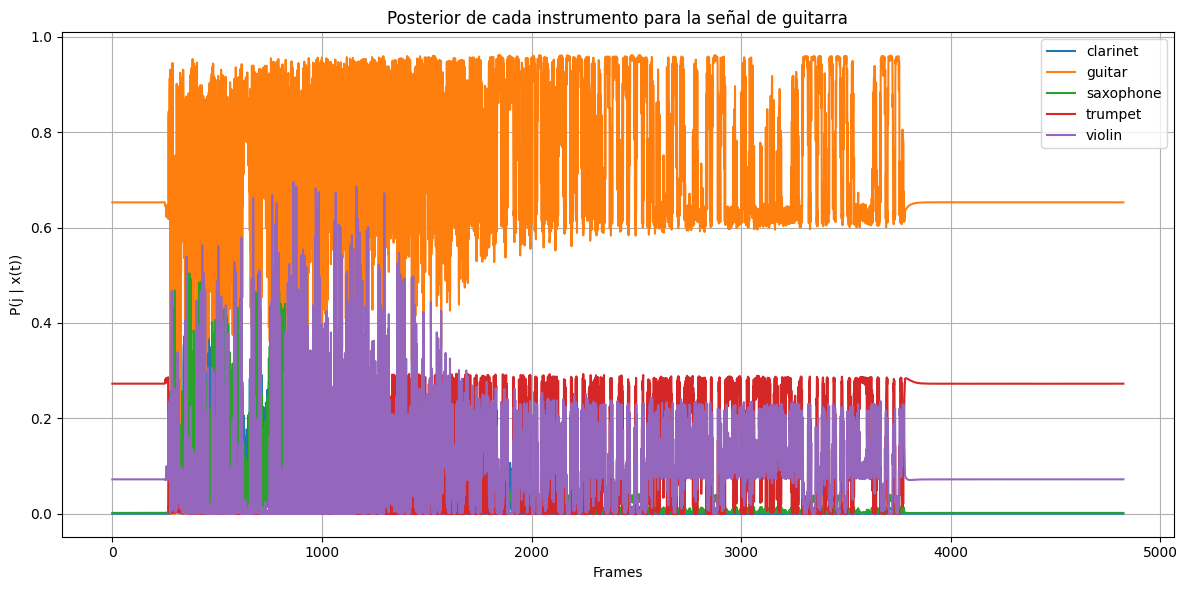

In [75]:
# 1) Obtener los frames ya procesados de la guitarra desde el diccionario
X_frames = X_test_frames['guitar']  # shape (n_frames, n_features)

# 2) Calcular log-verosimilitud de cada frame bajo cada GMM (uno por instrumento)
log_pxj = np.vstack([gmm_models[inst].score_samples(X_frames) for inst in instruments])  # shape (n_instruments, n_frames)

# 3) Calcular priors P(j) basado en X_train (diccionario)
conteo_train = {inst: len(señales) for inst, señales in X_train.items()}
total = sum(conteo_train.values())
priors = np.array([conteo_train.get(inst, 0) / total for inst in instruments])  # shape (n_instruments,)

# 4) Calcular posteriors P(j | x) para cada frame usando log-softmax
log_post = log_pxj + np.log(priors)[:, None]  # shape (n_instruments, n_frames)
posteriors = softmax(log_post, axis=0)        # shape (n_instruments, n_frames)

# 5) Graficar
plt.figure(figsize=(12, 6))
for j, inst in enumerate(instruments):
    plt.plot(np.arange(len(X_frames)), posteriors[j], label=inst)
plt.xlabel('Frames')
plt.ylabel('P(j | x(t))')
plt.title('Posterior de cada instrumento para la señal de guitarra')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



